In [1]:
import scipy.io as sio
import matplotlib.pyplot as plt
import numpy as np
import os
import torchio as tio
from options.test_options import TestOptions
import numpy as np
from models.models import create_model
from util.visualizer import Visualizer
from util import html
import torch
#from models.networks import Dense3DSpatialTransformer
from medipy.metrics import dice
import torch.nn.functional as F
import nrrd
import nibabel as nib
from scipy.ndimage import zoom
%matplotlib inline

In [2]:
class Params(dict):
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

    def __getstate__(self):
        return self

    def __setstate__(self, state):
        self.update(state)

    def copy(self, **extra_params):
        return Params(**self, **extra_params)

In [3]:
datapath = os.path.join('./generated_pairs_16/images/')
dataFiles  = sorted(os.listdir(datapath))
dataFiles = [i for i in dataFiles if not i.startswith('.')]
dataFiles = dataFiles[int(0.8*len(dataFiles)):]

In [4]:
len(dataFiles)

42

In [5]:
case_name = 'Brats18_2013_23_1'

In [6]:
case_name

'Brats18_2013_23_1'

In [7]:
opt = Params(
    nThreads = 1,
    batchSize = 1,
    isTrain = False,
    dataroot = './evaluation_pairs_16/images/' + case_name,
    labelroot = './generated_pairs_16/images/' + case_name, 
    gpu_ids = [0],          
    name_G = 'CycleMorph_brain_seg', 
    name = 'CycleMorph_brain_seg', 
    name_S = 'CycleMorph_brain_seg', 
    model = 'cycleregister',
    init_type = 'normal',
    continue_train = False,
    which_model_netS = 'unet',
    which_model_netG = 'registnet',              
    inputSize = (128,128,128), 
    fineSize = (128,128,128),  
    input_nc = 2,                
    encoder_nc = [16,32,32,32,32],
    decoder_nc = [32,32,32,16,16,1],
    which_epoch_S = 18,
    which_epoch_G = 18,
    which_epoch = 8,
    display_id = 1,
    display_winsize = 192,
    display_port = 8097,
    model_type = 'seg_align',
    phase = 'test',
    checkpoints_dir = './checkpoints/CycleMorph_brain_segalign_16/', 
    checkpoints_dir_G = './checkpoints/CycleMorph_brain_segalign_16/', 
    checkpoints_dir_S = './checkpoints/CycleMorph_brain_segalign_16/', 
    results_dir = './results/CycleMorph_brain_segalign_16/')
print(opt)

{'nThreads': 1, 'batchSize': 1, 'isTrain': False, 'dataroot': './evaluation_pairs_16/images/Brats18_2013_23_1', 'labelroot': './generated_pairs_16/images/Brats18_2013_23_1', 'gpu_ids': [0], 'name_G': 'CycleMorph_brain_seg', 'name': 'CycleMorph_brain_seg', 'name_S': 'CycleMorph_brain_seg', 'model': 'cycleregister', 'init_type': 'normal', 'continue_train': False, 'which_model_netS': 'unet', 'which_model_netG': 'registnet', 'inputSize': (128, 128, 128), 'fineSize': (128, 128, 128), 'input_nc': 2, 'encoder_nc': [16, 32, 32, 32, 32], 'decoder_nc': [32, 32, 32, 16, 16, 1], 'which_epoch_S': 18, 'which_epoch_G': 18, 'which_epoch': 8, 'display_id': 1, 'display_winsize': 192, 'display_port': 8097, 'model_type': 'seg_align', 'phase': 'test', 'checkpoints_dir': './checkpoints/CycleMorph_brain_segalign_16/', 'checkpoints_dir_G': './checkpoints/CycleMorph_brain_segalign_16/', 'checkpoints_dir_S': './checkpoints/CycleMorph_brain_segalign_16/', 'results_dir': './results/CycleMorph_brain_segalign_16/'}

In [8]:
def _toTorchFloatTensor(img):
    img = torch.from_numpy(img.copy())
    return img

model_regist = create_model(opt)
visualizer = Visualizer(opt)

# create website
web_dir = os.path.join(opt.results_dir, opt.name, '%s_%s' % (opt.phase, opt.which_epoch))
webpage = html.HTML(web_dir, 'Experiment = %s, Phase = %s, Epoch = %s' %
                    (opt.name, opt.phase, opt.which_epoch))

cycleregister
model type: seg_align
initialization method [normal]
AvgPool3d
Conv3d
AvgPool3d
ReLU
Sequential
Conv3d
AvgPool3d
ReLU
Sequential
Conv3d
AvgPool3d
ReLU
Sequential
Linear
ReLU
Sequential
Linear
Linear
registerNet
DataParallel
registerNeter


/home/hg119/lab/fracture/MEDIA_CycleBrain/models/stn_networks.py:309: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  init.normal(m.weight.data, 0.0, 0.02)
Setting up a new session...
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/urllib3/connection.py", line 170, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw
  File "/opt/conda/lib/python3.7/site-packages/urllib3/util/connection.py", line 96, in create_connection
    raise err
  File "/opt/conda/lib/python3.7/site-packages/urllib3/util/connection.py", line 86, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/urllib3/connectionpool.py", line 706, in urlopen
    chunked=chunked,
  File "/opt/conda/lib/python3.7/site-packages/urllib3/connectionpool.py", l

model [cycleregister] was created
Exception in user code:
------------------------------------------------------------


[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
Visdom python client failed to establish socket to get messages from the server. This feature is optional and can be disabled by initializing Visdom with `use_incoming_socket=False`, which will prevent waiting for this request to timeout.


In [9]:
def rot2eul(R):
    beta = -np.arcsin(R[2,0])
    alpha = np.arctan2(R[2,1]/np.cos(beta),R[2,2]/np.cos(beta))
    gamma = np.arctan2(R[1,0]/np.cos(beta),R[0,0]/np.cos(beta))
    return np.array((alpha, beta, gamma))
def test(dataFile,labelFile,regist_cnt=3):
    train_transforms = tio.Compose([tio.RescaleIntensity(out_min_max=(0, 1))                             
    ])
    print('test volume = %s' % (dataFile))
    label = nib.load(labelFile)
    labels = np.array([1,2])
    datafiles = [dataFile]
    originDice = np.zeros((len(datafiles), labels.shape[0]))
    registDice = np.zeros((len(datafiles), labels.shape[0]))
    readdata1 = np.array(label.dataobj)
    #atlas = np.load(os.path.join(opt.labelroot, 'atlas_norm.npz'))
    label_vol = zoom(np.array(readdata1),(1/2,1/2,1/2),order=1)
    label_vol = np.expand_dims(label_vol,axis=0)
    img= nib.load(dataFile)
    readdata1 = np.array(img.dataobj)
    data = np.expand_dims(readdata1,axis=0)
    data = zoom(data,(1,1/2,1/2,1/2),order=1)
    data_vol = train_transforms(tio.ScalarImage(tensor = data))[tio.DATA].float()
    label_vol = label_vol / (label_vol.max()*1.0)
    #label_vol = train_transforms(tio.ScalarImage(tensor =label_vol))[tio.DATA].float()

    test_dataA = data_vol.reshape(1, 1, 128, 128, 128)
    test_dataB = torch.tensor(label_vol.reshape((1, 1, 128, 128, 128))).float()
    batch_x = test_dataA
    batch_y = test_dataB
    ###################################################

    test_data = {'A': batch_x, 'B': batch_y,'M_A':batch_x, 'M_B':batch_y,'path': dataFile}
    model_regist.set_input(test_data)
    model_regist.test()
    visuals = model_regist.get_current_data()
    
    regist_flow = visuals['flow_A'].permute(0,4,1,2,3).cpu().float().numpy()

    regist_data = visuals['fake_B']
    regist_data = regist_data.cpu().float().numpy()[0, 0]
    regist_data = np.array(regist_data,dtype=float)
    label_vol = np.array(label_vol[0],dtype=float)
    origin_data = np.array(data_vol[0],dtype=float)
    pre_segA = torch.sigmoid(visuals['seg_A']).cpu().float().numpy()[0, 0]
    pre_segB = torch.sigmoid(visuals['seg_B']).cpu().float().numpy()[0, 0]
    regist_mask = F.grid_sample(torch.sigmoid(visuals['seg_A']), visuals['flow_A']).cpu().float().numpy()[0, 0]
    vals_regist, _ = dice(regist_data>0.1, label_vol>0.1,nargout=2)
    vals_origin, _ = dice(origin_data>0.1, label_vol>0.1,nargout=2)
    registDice[0] = vals_regist
    originDice[0] = vals_origin
    print(np.mean(vals_regist))
    print(np.mean(vals_origin))
    pre_theta = torch.unsqueeze(torch.concat([visuals['theta'],torch.tensor([[0,0,0,1]])],0),0)
    seg_pre = visuals['seg_A']
    for i in range(regist_cnt):
        batch_x = visuals['fake_B']
        batch_y = test_dataB
        test_data = {'A': batch_x, 'B': batch_y,'M_A':batch_x, 'M_B':batch_y,'path': dataFile}
        model_regist.set_input(test_data)
        model_regist.test()
        visuals = model_regist.get_current_data()

        regist_flow = visuals['flow_A'].permute(0,4,1,2,3).cpu().float().numpy()

        regist_data = visuals['fake_B']
        regist_data = regist_data.cpu().float().numpy()[0, 0]
        regist_data = np.array(regist_data,dtype=float)
        pre_theta = torch.bmm(torch.unsqueeze(torch.concat([visuals['theta'],torch.tensor([[0,0,0,1]])],0),0),pre_theta)
        vals_regist, _ = dice(regist_data>0.1, label_vol>0.1,nargout=2)
        vals_origin, _ = dice(origin_data>0.1, label_vol>0.1,nargout=2)


        
        #vals_regist, _ = dice(regist_mask>0.5, pre_segB>0.5,nargout=2)
        #vals_origin, _ = dice(pre_segA>0.5, pre_segB>0.5,nargout=2)
        print(np.mean(vals_regist))
        print(np.mean(vals_origin))
    alpha,beta,gamma = rot2eul(np.linalg.inv(pre_theta[0])[0:3, :])
    tx,ty,tz = pre_theta[0][0][2],pre_theta[0][1][2],pre_theta[0][2][2]
    print(-gamma,-beta,-alpha,-tz,-ty,-tx)
    grid = F.affine_grid(pre_theta[:, 0:3, :], seg_pre.size())
    regist_mask = F.grid_sample(torch.sigmoid(seg_pre).cpu(), grid).cpu().float().numpy()[0, 0]
    #regist_data = F.grid_sample(batch_x.cpu(), grid).cpu().float().numpy()[0, 0]
    return regist_data,grid,origin_data,label_vol,pre_segA,pre_segB,regist_mask,pre_theta

[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99]

In [68]:
case_name = dataFiles[14]

In [50]:
mask = tio.ScalarImage(os.path.join('HGG',case_name,case_name+'_seg.nii.gz'))
transform = tio.CropOrPad(
    (256, 256, 256),
)
mask = transform(mask).data
high_mask = mask
dataroot = './evaluation_pairs_16/images/' + case_name
labelroot = './generated_pairs_16/images/' + case_name
####### Image Pre-processing ##############################################
img_name = 'x.nii.gz'
dataFile= os.path.join(dataroot, img_name)
labelFile = os.path.join(labelroot, img_name)
aligned_img_x,regist_flow,image_x,gt_x,pre_segA_x,pre_segB_x,regist_mask_x,pre_theta = test(dataFile,labelFile)
eval_mask= nib.load(os.path.join('./evaluation_pairs_16/masks/',case_name,img_name))
readdata1 = np.array(eval_mask.dataobj)
mask = np.expand_dims(readdata1,axis=0)
low_mask_x = zoom(mask,(1,1/2,1/2,1/2),order=1)
print('dice for low resolution mask x')
print(dice(np.array(pre_segA_x)>0.5, np.array(low_mask_x[0])>0.1,nargout=1))
print('dice for high resolution mask x')
print(dice(np.array(zoom(regist_mask_x,(2,2,2),order=1))>0.5, np.array(high_mask[0])>0.1,nargout=1))

img_name = 'y.nii.gz'
dataFile= os.path.join(dataroot, img_name)
labelFile = os.path.join(labelroot, img_name)
aligned_img_y,regist_flow,image_y,gt_y,pre_segA_y,pre_segB_y,regist_mask_y,pre_theta = test(dataFile,labelFile)
eval_mask= nib.load(os.path.join('./evaluation_pairs_16/masks/',case_name,img_name))
readdata1 = np.array(eval_mask.dataobj)
mask = np.expand_dims(readdata1,axis=0)
low_mask_y = zoom(mask,(1,1/2,1/2,1/2),order=1)
print('dice for low resolution mask y')
print(dice(np.array(pre_segA_y)>0.5, np.array(low_mask_y[0])>0.1,nargout=1))
print('dice for high resolution mask y')
print(dice(np.array(zoom(regist_mask_y,(2,2,2),order=1))>0.5, np.array(high_mask[0])>0.1,nargout=1))

img_name = 'z.nii.gz'
dataFile= os.path.join(dataroot, img_name)
labelFile = os.path.join(labelroot, img_name)
aligned_img_z,regist_flow,image_z,gt_z,pre_segA_z,pre_segB_z,regist_mask_z,pre_theta = test(dataFile,labelFile)
eval_mask= nib.load(os.path.join('./evaluation_pairs_16/masks/',case_name,img_name))
readdata1 = np.array(eval_mask.dataobj)
mask = np.expand_dims(readdata1,axis=0)
low_mask_z = zoom(mask,(1,1/2,1/2,1/2),order=1)
print('dice for low resolution mask z')
print(dice(np.array(pre_segA_z)>0.5, np.array(low_mask_z[0])>0.1,nargout=1))
print('dice for high resolution mask z')
print(dice(np.array(zoom(regist_mask_z,(2,2,2),order=1))>0.5, np.array(high_mask[0])>0.1,nargout=1))

test volume = ./evaluation_pairs_16/images/Brats18_TCIA04_437_1/x.nii.gz
0.9181840878599903
0.9169711281411513
0.9182689156415915
0.9169711281411513
0.9182318542390364
0.9169711281411513
0.9183534860631122
0.9169711281411513
0.023945296 0.017566795 0.003056702 tensor(-0.9998) tensor(0.0031) tensor(-0.0176)
dice for low resolution mask x
[0.8458498]
dice for high resolution mask x
[0.74661046]
test volume = ./evaluation_pairs_16/images/Brats18_TCIA04_437_1/y.nii.gz
0.9243457851674746
0.8709412156906323
0.9351876775833707
0.8709412156906323
0.9386973490964857
0.8709412156906323
0.9369789858173783
0.8709412156906323
0.05883794 0.5213364 0.027717568 tensor(-0.8668) tensor(0.0240) tensor(-0.4980)
dice for low resolution mask y
[0.60705669]
dice for high resolution mask y
[0.48514158]
test volume = ./evaluation_pairs_16/images/Brats18_TCIA04_437_1/z.nii.gz
0.9115543226847317
0.8297106288258208
0.9136154656489797
0.8297106288258208
0.9136729717547261
0.8297106288258208
0.9137587698117712
0.82

In [51]:
print(dice(np.array(zoom(pre_segA_x,(2,2,2),order=1))>0.5, np.array(high_mask[0])>0.5,nargout=1))

[0.75289186]


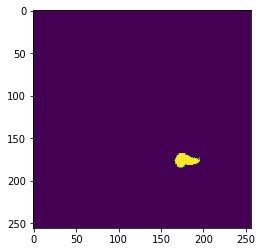

In [52]:
plt.imshow(np.array(high_mask)[0,:,:,121]>0.5)

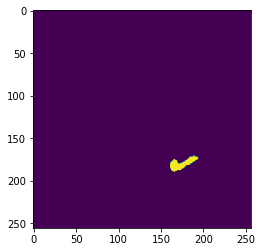

In [53]:
plt.imshow(np.array(zoom(pre_segA_x,(2,2,2),order=1))[:,:,111]>0.5)

In [ ]:
plt.imshow(np.array(pre_segA_x)[:,:,65])

In [55]:
img= tio.ScalarImage(os.path.join('gt_pairs_16/images',case_name,'x.nii.gz'))
gt_x = np.array(torch.squeeze(transform(img).data))

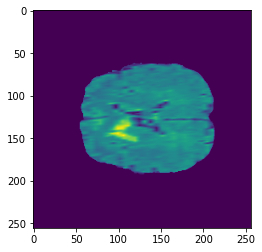

In [60]:
plt.imshow(gt_x[:,:,128])

In [76]:
transform = tio.CropOrPad(
    (256, 256, 256),
)
save_folder = 'test_seg_results_128_16'
regist_mask_x = tio.ScalarImage(os.path.join(dataroot,'x.nii.gz')).data
obj_x = regist_mask_x
def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))
def gaussian_filter(size):
    x = np.linspace(-size,size,2*size+1)
    gauss_x = gaussian(x,0,size/2)
    return gauss_x
for i in range(len(dataFiles)):
    case_name = dataFiles[i]
    img= tio.ScalarImage(os.path.join('gt_pairs_16/images',case_name,'x.nii.gz'))
    gt_x = np.array(torch.squeeze(transform(img).data))
    img= tio.ScalarImage(os.path.join('gt_pairs_16/images',case_name,'y.nii.gz'))
    gt_y = np.array(torch.squeeze(transform(img).data))
    img = tio.ScalarImage(os.path.join('gt_pairs_16/images',case_name,'z.nii.gz'))
    gt_z = np.array(torch.squeeze(transform(img).data))

    filter_size = 9
    x = gaussian_filter(filter_size)
    prob_x = np.zeros(obj_x.data.shape)
    for i in range(obj_x.data.shape[1]):
        for j in range(obj_x.data.shape[2]):
            prob_x[0,i,j,:] = np.convolve(x,np.array(gt_x[i,j,:]>0.5,dtype=float))[filter_size:-filter_size]
    prob_y = np.zeros(obj_x.data.shape)
    for i in range(obj_x.data.shape[1]):
        for j in range(obj_x.data.shape[3]):
            prob_y[0,i,:,j] = np.convolve(x,np.array(gt_y[i,:,j]>0.5,dtype=float))[filter_size:-filter_size]
    prob_z = np.zeros(obj_x.data.shape)
    for i in range(obj_x.data.shape[1]):
        for j in range(obj_x.data.shape[2]):
            prob_z[0,:,i,j] = np.convolve(x,np.array(gt_z[:,i,j]>0.5,dtype=float))[filter_size:-filter_size]
    if not os.path.exists(os.path.join(save_folder,case_name)):
        os.mkdir(os.path.join(save_folder,case_name))
    tio.ScalarImage(tensor=torch.Tensor(prob_x)).save(os.path.join(save_folder,case_name,'prob_x.nii.gz'))
    tio.ScalarImage(tensor=torch.Tensor(prob_y)).save(os.path.join(save_folder,case_name,'prob_y.nii.gz'))
    tio.ScalarImage(tensor=torch.Tensor(prob_z)).save(os.path.join(save_folder,case_name,'prob_z.nii.gz'))

In [64]:
image = tio.ScalarImage(os.path.join('HGG',case_name,case_name+'_flair.nii.gz'))
transform = tio.CropOrPad(
    (256, 256, 256),
)
image = transform(image).data
high_reso_image = image
high_reso_image = np.array((high_reso_image / high_reso_image.max()*1.0)*255,dtype=np.uint8)

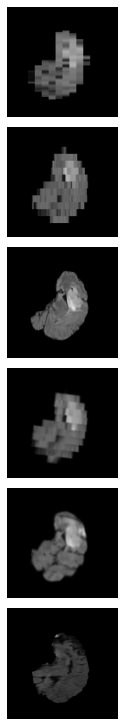

In [65]:
fig,a =  plt.subplots(6,1, figsize=(10,10))
a[0].imshow(image_x[65,:,:],cmap='gray',vmin=0, vmax=1)
#a[0].set_title('view1')
a[0].axis(False)
a[1].imshow(image_y[65,:,:],cmap='gray',vmin=0, vmax=1)
#a[1].set_title('view2')
a[1].axis(False)
a[2].imshow(image_z[65,:,:],cmap='gray',vmin=0, vmax=1)
#a[2].set_title('view3')
a[2].axis(False)
a[3].imshow(aligned_img_y[65,:,:],cmap='gray',vmin=0, vmax=1)
#a[1].set_title('view2')
a[3].axis(False)
a[4].imshow(aligned_img_z[65,:,:],cmap='gray',vmin=0, vmax=1)
#a[2].set_title('view3')
a[4].axis(False)
a[5].imshow(high_reso_image[0,130,:,:],cmap='gray',vmin=0, vmax=255)
#a[2].set_title('view3')
a[5].axis(False)
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

In [22]:
save_folder = 'test_seg_results_128'
if not os.path.exists(os.path.join(save_folder,case_name)):
    os.mkdir(os.path.join(save_folder,case_name))
tio.ScalarImage(tensor=torch.unsqueeze(torch.Tensor(gt_x),0)).save(os.path.join(save_folder,case_name,'gt_x.nii.gz'))
tio.ScalarImage(tensor=torch.unsqueeze(torch.Tensor(gt_y),0)).save(os.path.join(save_folder,case_name,'gt_y.nii.gz'))
tio.ScalarImage(tensor=torch.unsqueeze(torch.Tensor(gt_z),0)).save(os.path.join(save_folder,case_name,'gt_z.nii.gz'))
tio.ScalarImage(tensor=torch.unsqueeze(torch.Tensor(pre_segA_x),0)).save(os.path.join(save_folder,case_name,'pre_seg_x.nii.gz'))
tio.ScalarImage(tensor=torch.unsqueeze(torch.Tensor(pre_segA_y),0)).save(os.path.join(save_folder,case_name,'pre_seg_y.nii.gz'))
tio.ScalarImage(tensor=torch.unsqueeze(torch.Tensor(pre_segA_z),0)).save(os.path.join(save_folder,case_name,'pre_seg_z.nii.gz'))
tio.ScalarImage(tensor=torch.unsqueeze(torch.Tensor(image_x),0)).save(os.path.join(save_folder,case_name,'image_x.nii.gz'))
tio.ScalarImage(tensor=torch.unsqueeze(torch.Tensor(image_y),0)).save(os.path.join(save_folder,case_name,'image_y.nii.gz'))
tio.ScalarImage(tensor=torch.unsqueeze(torch.Tensor(image_z),0)).save(os.path.join(save_folder,case_name,'image_z.nii.gz'))

In [12]:
def OS(mask_a,mask_b):
    mask_a = mask_a.flatten()
    mask_b = mask_b.flatten()
    return 1-np.sum(np.logical_and(mask_a,mask_b))/np.sum(mask_b)
def US(mask_a,mask_b):
    mask_a = mask_a.flatten()
    mask_b = mask_b.flatten()
    return 1-np.sum(np.logical_and(mask_a,mask_b))/np.sum(mask_a)
def RMS(mask_a,mask_b):
    return np.sqrt((OS(mask_a,mask_b)**2+US(mask_a,mask_b)**2)/2)
def AFI(mask_a,mask_b):
    return 0

[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given


In [13]:
i

0

In [69]:
low_dice_x_list = []
low_dice_y_list = []
low_dice_z_list = []
high_dice_x_list = []
high_dice_y_list = []
high_dice_z_list = []
OS_x_list = []
US_x_list = []
OS_y_list = []
US_y_list = []
OS_z_list = []
US_z_list = []
RMS_x_list = []
RMS_y_list = []
RMS_z_list = []
save_folder = 'test_seg_results_128_16'
for i in range(0,len(dataFiles)):
    case_name = dataFiles[i]
    dataroot = './evaluation_pairs_16/images/' + case_name
    labelroot = './generated_pairs_16/images/' + case_name
    mask = tio.ScalarImage(os.path.join('HGG',case_name,case_name+'_seg.nii.gz'))
    resample = tio.Resample((1,1,1),image_interpolation='nearest')
    mask = resample(mask)
    transform = tio.CropOrPad(
        (256, 256, 256),
    )
    mask = transform(mask).data
    high_mask = mask

    ####### Image Pre-processing ##############################################
    img_name = 'x.nii.gz'
    dataFile= os.path.join(dataroot, img_name)
    labelFile = os.path.join(labelroot, img_name)
    aligned_img_x,regist_flow,image_x,gt_x,pre_segA_x,pre_segB_x,regist_mask_x,pre_theta = test(dataFile,labelFile)
    prob_x =  tio.ScalarImage(os.path.join(save_folder,case_name,'prob_x.nii.gz')).data
    regist_prob_x = prob_x.float().numpy()[0]
    
    
    eval_mask= nib.load(os.path.join('./evaluation_pairs_16/masks/',case_name,img_name))
    readdata1 = np.array(eval_mask.dataobj)
    mask = np.expand_dims(readdata1,axis=0)
    low_mask_x = zoom(mask,(1,1/2,1/2,1/2),order=1)
    dice_low = dice(np.array(pre_segA_x)>0.5, np.array(low_mask_x[0])>0.1,nargout=1)
    low_dice_x_list.append(dice_low[0])
    print('dice for low resolution mask x')
    print(dice_low)
    print('dice for high resolution mask x')
    dice_high = dice(np.array(zoom(pre_segA_x,(2,2,2),order=1))>0.5, np.array(high_mask[0])>0.1,nargout=1)
    high_dice_x_list.append(dice_high[0])
    print(dice_high)
    OS_x_list.append(OS(np.array(zoom(pre_segA_x,(2,2,2),order=1))>0.5, np.array(high_mask[0])>0.1))
    US_x_list.append(US(np.array(zoom(pre_segA_x,(2,2,2),order=1))>0.5, np.array(high_mask[0])>0.1))
    RMS_x_list.append(RMS(np.array(zoom(pre_segA_x,(2,2,2),order=1))>0.5, np.array(high_mask[0])>0.1))

    img_name = 'y.nii.gz'
    dataFile= os.path.join(dataroot, img_name)
    labelFile = os.path.join(labelroot, img_name)
    aligned_img_y,regist_flow,image_y,gt_y,pre_segA_y,pre_segB_y,regist_mask_y,pre_theta = test(dataFile,labelFile)
    
    prob_y =torch.unsqueeze(tio.ScalarImage(os.path.join(save_folder,case_name,'prob_y.nii.gz')).data,0)

    grid = F.affine_grid(pre_theta[:, 0:3, :], prob_y.size())
    regist_prob_y = F.grid_sample(prob_y, grid).float().numpy()[0, 0]
    
    eval_mask= nib.load(os.path.join('./evaluation_pairs_16/masks/',case_name,img_name))
    readdata1 = np.array(eval_mask.dataobj)
    mask = np.expand_dims(readdata1,axis=0)
    low_mask_y = zoom(mask,(1,1/2,1/2,1/2),order=1)
    dice_low = dice(np.array(pre_segA_y)>0.5, np.array(low_mask_y[0])>0.1,nargout=1)
    low_dice_y_list.append(dice_low[0])
    print('dice for low resolution mask y')
    print(dice_low)
    print('dice for high resolution mask y')
    dice_high = dice(np.array(zoom(regist_mask_y,(2,2,2),order=1))>0.5, np.array(high_mask[0])>0.1,nargout=1)
    high_dice_y_list.append(dice_high[0])
    print(dice_high)
    OS_y_list.append(OS(np.array(zoom(regist_mask_y,(2,2,2),order=1))>0.5, np.array(high_mask[0])>0.1))
    US_y_list.append(US(np.array(zoom(regist_mask_y,(2,2,2),order=1))>0.5, np.array(high_mask[0])>0.1))
    RMS_y_list.append(OS(np.array(zoom(regist_mask_y,(2,2,2),order=1))>0.5, np.array(high_mask[0])>0.1))

    img_name = 'z.nii.gz'
    dataFile= os.path.join(dataroot, img_name)
    labelFile = os.path.join(labelroot, img_name)
    aligned_img_z,regist_flow,image_z,gt_z,pre_segA_z,pre_segB_z,regist_mask_z,pre_theta = test(dataFile,labelFile)
    
    prob_z = torch.unsqueeze(tio.ScalarImage(os.path.join(save_folder,case_name,'prob_z.nii.gz')).data,0)
    grid = F.affine_grid(pre_theta[:, 0:3, :], prob_z.size())
    regist_prob_z = F.grid_sample(prob_z, grid).float().numpy()[0, 0]
    
    eval_mask= nib.load(os.path.join('./evaluation_pairs_16/masks/',case_name,img_name))
    readdata1 = np.array(eval_mask.dataobj)
    mask = np.expand_dims(readdata1,axis=0)
    low_mask_z = zoom(mask,(1,1/2,1/2,1/2),order=1)
    dice_low = dice(np.array(pre_segA_z)>0.5, np.array(low_mask_z[0])>0.1,nargout=1)
    low_dice_z_list.append(dice_low[0])
    print('dice for low resolution mask z')
    print(dice_low)
    print('dice for high resolution mask z')
    dice_high = dice(np.array(zoom(regist_mask_z,(2,2,2),order=1))>0.5, np.array(high_mask[0])>0.1,nargout=1)
    high_dice_z_list.append(dice_high[0])
    print(dice_high)
    OS_z_list.append(OS(np.array(zoom(regist_mask_z,(2,2,2),order=1))>0.5, np.array(high_mask[0])>0.1))
    US_z_list.append(US(np.array(zoom(regist_mask_z,(2,2,2),order=1))>0.5, np.array(high_mask[0])>0.1))
    RMS_z_list.append(OS(np.array(zoom(regist_mask_z,(2,2,2),order=1))>0.5, np.array(high_mask[0])>0.1))

    if not os.path.exists(os.path.join(save_folder,case_name)):
        os.mkdir(os.path.join(save_folder,case_name))
    tio.ScalarImage(tensor=torch.unsqueeze(torch.Tensor(gt_x),0)).save(os.path.join(save_folder,case_name,'gt_x.nii.gz'))
    tio.ScalarImage(tensor=torch.unsqueeze(torch.Tensor(gt_y),0)).save(os.path.join(save_folder,case_name,'gt_y.nii.gz'))
    tio.ScalarImage(tensor=torch.unsqueeze(torch.Tensor(gt_z),0)).save(os.path.join(save_folder,case_name,'gt_z.nii.gz'))
    
    tio.ScalarImage(tensor=torch.unsqueeze(torch.Tensor(aligned_img_x),0)).save(os.path.join(save_folder,case_name,'aligned_img_x.nii.gz'))
    tio.ScalarImage(tensor=torch.unsqueeze(torch.Tensor(aligned_img_y),0)).save(os.path.join(save_folder,case_name,'aligned_img_y.nii.gz'))
    tio.ScalarImage(tensor=torch.unsqueeze(torch.Tensor(aligned_img_z),0)).save(os.path.join(save_folder,case_name,'aligned_img_z.nii.gz'))
    
    tio.ScalarImage(tensor=torch.unsqueeze(torch.Tensor(regist_mask_x),0)).save(os.path.join(save_folder,case_name,'regist_mask_x.nii.gz'))
    tio.ScalarImage(tensor=torch.unsqueeze(torch.Tensor(regist_mask_y),0)).save(os.path.join(save_folder,case_name,'regist_mask_y.nii.gz'))
    tio.ScalarImage(tensor=torch.unsqueeze(torch.Tensor(regist_mask_z),0)).save(os.path.join(save_folder,case_name,'regist_mask_z.nii.gz'))
    
    tio.ScalarImage(tensor=torch.unsqueeze(torch.Tensor(regist_prob_x),0)).save(os.path.join(save_folder,case_name,'regist_prob_x.nii.gz'))
    tio.ScalarImage(tensor=torch.unsqueeze(torch.Tensor(regist_prob_y),0)).save(os.path.join(save_folder,case_name,'regist_prob_y.nii.gz'))
    tio.ScalarImage(tensor=torch.unsqueeze(torch.Tensor(regist_prob_z),0)).save(os.path.join(save_folder,case_name,'regist_prob_z.nii.gz'))
    
    tio.ScalarImage(tensor=torch.unsqueeze(torch.Tensor(pre_segA_x),0)).save(os.path.join(save_folder,case_name,'pre_seg_x.nii.gz'))
    tio.ScalarImage(tensor=torch.unsqueeze(torch.Tensor(pre_segA_y),0)).save(os.path.join(save_folder,case_name,'pre_seg_y.nii.gz'))
    tio.ScalarImage(tensor=torch.unsqueeze(torch.Tensor(pre_segA_z),0)).save(os.path.join(save_folder,case_name,'pre_seg_z.nii.gz'))
    
    tio.ScalarImage(tensor=torch.unsqueeze(torch.Tensor(zoom(pre_segA_x,(2,2,2),order=1)*255),0)).save(os.path.join(save_folder,case_name,'resized_pre_seg_x.nii.gz'))
    
    tio.ScalarImage(tensor=torch.unsqueeze(torch.Tensor(image_x),0)).save(os.path.join(save_folder,case_name,'image_x.nii.gz'))
    tio.ScalarImage(tensor=torch.unsqueeze(torch.Tensor(image_y),0)).save(os.path.join(save_folder,case_name,'image_y.nii.gz'))
    tio.ScalarImage(tensor=torch.unsqueeze(torch.Tensor(image_z),0)).save(os.path.join(save_folder,case_name,'image_z.nii.gz'))

test volume = ./evaluation_pairs_16/images/Brats18_TCIA03_138_1/x.nii.gz
0.8995613727171998
0.8956389176912063
0.9015358855316234
0.8956389176912063
0.9017857142857143
0.8956389176912063
0.902310937139106
0.8956389176912063
-0.0313115 -0.01020107 -0.006058651 tensor(-0.9999) tensor(-0.0061) tensor(0.0102)
dice for low resolution mask x
[0.92527179]
dice for high resolution mask x
[0.84601219]
test volume = ./evaluation_pairs_16/images/Brats18_TCIA03_138_1/y.nii.gz
0.9072339691139444
0.7979650080655168
0.9152110514198004
0.7979650080655168
0.9189897523980981
0.7979650080655168
0.9203253820612214
0.7979650080655168
0.096590646 -0.07332618 -0.4074471 tensor(-0.9157) tensor(-0.3952) tensor(0.0733)
dice for low resolution mask y
[0.91583411]
dice for high resolution mask y
[0.86762286]
test volume = ./evaluation_pairs_16/images/Brats18_TCIA03_138_1/z.nii.gz
0.8878523738872404
0.7979561117607543
0.8927494819298997
0.7979561117607543
0.8952603825967318
0.7979561117607543
0.8972789386726665
0.

In [ ]:
np.array(high_dice_z_list).mean()

In [13]:
def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))
def gaussian_filter(size):
    x = np.linspace(-size,size,2*size+1)
    gauss_x = gaussian(x,0,size/2)
    return gauss_x

[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given


In [ ]:
case_name = dataFiles[1]

In [56]:
fusion_dice_list =[]
OS_list = []
US_list = []
RMS_list = []
save_folder = 'test_seg_results_128_16'
for i in range(len(dataFiles)):
    case_name = dataFiles[i]
    if os.path.exists(os.path.join('./gt_pairs_16/images',case_name,'x.nii.gz')):
        mask = tio.ScalarImage(os.path.join('HGG',case_name,case_name+'_seg.nii.gz'))
        transform = tio.CropOrPad(
            (256, 256, 256),
        )
        mask = transform(mask).data
        high_mask = mask


        regist_mask_x = tio.ScalarImage(os.path.join(save_folder,case_name,'pre_seg_x.nii.gz')).data
        regist_mask_y = tio.ScalarImage(os.path.join(save_folder,case_name,'regist_mask_y.nii.gz')).data
        regist_mask_z = tio.ScalarImage(os.path.join(save_folder,case_name,'regist_mask_z.nii.gz')).data

        obj_x = zoom(np.array(regist_mask_x),(1,2,2,2),order=1)
        obj_y = zoom(np.array(regist_mask_y),(1,2,2,2),order=1)
        obj_z = zoom(np.array(regist_mask_z),(1,2,2,2),order=1)

        prob_x = tio.ScalarImage(os.path.join(save_folder,case_name,'regist_prob_x.nii.gz')).data.numpy()
        prob_y = tio.ScalarImage(os.path.join(save_folder,case_name,'regist_prob_y.nii.gz')).data.numpy()
        prob_z = tio.ScalarImage(os.path.join(save_folder,case_name,'regist_prob_z.nii.gz')).data.numpy()

        final_image = np.zeros(obj_x.size)
        prob_x_flatten = prob_x.flatten()
        prob_y_flatten = prob_y.flatten()
        prob_z_flatten = prob_z.flatten()
        map_x_flatten = obj_x.flatten()
        map_y_flatten = obj_y.flatten()
        map_z_flatten = obj_z.flatten()
        for idx in range(prob_x_flatten.size):
            if prob_x_flatten[idx]+prob_y_flatten[idx]+prob_z_flatten[idx]>0.4:
                ratio = (prob_x_flatten[idx]+prob_y_flatten[idx]+prob_z_flatten[idx])
                prob_x_flatten[idx], prob_y_flatten[idx], prob_z_flatten[idx] = \
                prob_x_flatten[idx]/ratio ,prob_y_flatten[idx]/ratio,prob_z_flatten[idx]/ratio 
                final_image[idx] = prob_x_flatten[idx]*map_x_flatten[idx]+prob_y_flatten[idx]*map_y_flatten[idx]+prob_z_flatten[idx]*map_z_flatten[idx]
        final_image = np.clip(np.round(final_image*1),0,a_max=1).reshape(prob_x.shape)
        dice_high_fusion =  dice(np.array(final_image[0])>0.5, np.array(high_mask[0])>0.1,nargout=1)
        OS_list.append(OS(np.array(final_image[0])>0.5, np.array(high_mask[0])>0.1))
        US_list.append(US(np.array(final_image[0])>0.5, np.array(high_mask[0])>0.1))
        RMS_list.append(RMS(np.array(final_image[0])>0.5, np.array(high_mask[0])>0.1))

        dice_before_x = dice(obj_x[0]>0.5, np.array(high_mask[0])>0.1,nargout=1)
        dice_before_y = dice(obj_y[0]>0.5, np.array(high_mask[0])>0.1,nargout=1)
        dice_before_z = dice(obj_z[0]>0.5, np.array(high_mask[0])>0.1,nargout=1)
        print('orignal_x dice: %f, orginal_y dice: %f, orginal_z dice: %.2f, final fusion dice: %.2f'%(dice_before_x,dice_before_y,dice_before_z,dice_high_fusion))
        fusion_dice_list.append(dice_high_fusion)
        
        tio.ScalarImage(tensor=torch.Tensor(final_image)).save(os.path.join(save_folder,case_name,'final_mask.nii.gz'))

orignal_x dice: 0.846012, orginal_y dice: 0.867623, orginal_z dice: 0.82, final fusion dice: 0.89
orignal_x dice: 0.760772, orginal_y dice: 0.772792, orginal_z dice: 0.74, final fusion dice: 0.78
orignal_x dice: 0.834870, orginal_y dice: 0.849312, orginal_z dice: 0.77, final fusion dice: 0.87
orignal_x dice: 0.859543, orginal_y dice: 0.774716, orginal_z dice: 0.83, final fusion dice: 0.84
orignal_x dice: 0.766100, orginal_y dice: 0.739723, orginal_z dice: 0.64, final fusion dice: 0.77
orignal_x dice: 0.807109, orginal_y dice: 0.825847, orginal_z dice: 0.77, final fusion dice: 0.85
orignal_x dice: 0.858473, orginal_y dice: 0.871726, orginal_z dice: 0.82, final fusion dice: 0.89
orignal_x dice: 0.852092, orginal_y dice: 0.828203, orginal_z dice: 0.77, final fusion dice: 0.86
orignal_x dice: 0.795417, orginal_y dice: 0.816605, orginal_z dice: 0.72, final fusion dice: 0.82
orignal_x dice: 0.837138, orginal_y dice: 0.808215, orginal_z dice: 0.70, final fusion dice: 0.84
orignal_x dice: 0.84

In [58]:
np.mean(fusion_dice_list)

0.8365199291724357

In [14]:
fusion_dice_list =[]
OS_list = []
US_list = []
RMS_list = []
save_folder = 'test_seg_results_128_16'
for i in range(len(dataFiles)):
    case_name = dataFiles[i]
    if os.path.exists(os.path.join('./gt_pairs_16/images',case_name,'x.nii.gz')):
        mask = tio.ScalarImage(os.path.join('HGG',case_name,case_name+'_seg.nii.gz'))
        transform = tio.CropOrPad(
            (256, 256, 256),
        )
        mask = transform(mask).data
        high_mask = mask


        regist_mask_x = tio.ScalarImage(os.path.join(save_folder,case_name,'pre_seg_x.nii.gz')).data
        regist_mask_y = tio.ScalarImage(os.path.join(save_folder,case_name,'regist_mask_y.nii.gz')).data

        obj_x = zoom(np.array(regist_mask_x),(1,2,2,2),order=1)
        obj_y = zoom(np.array(regist_mask_y),(1,2,2,2),order=1)

        prob_x = tio.ScalarImage(os.path.join(save_folder,case_name,'regist_prob_x.nii.gz')).data.numpy()
        prob_y = tio.ScalarImage(os.path.join(save_folder,case_name,'regist_prob_y.nii.gz')).data.numpy()

        final_image = np.zeros(obj_x.size)
        prob_x_flatten = prob_x.flatten()
        prob_y_flatten = prob_y.flatten()
        map_x_flatten = obj_x.flatten()
        map_y_flatten = obj_y.flatten()
        for idx in range(prob_x_flatten.size):
            if prob_x_flatten[idx]+prob_y_flatten[idx]>0.4:
                ratio = prob_x_flatten[idx]+prob_y_flatten[idx]
                prob_x_flatten[idx], prob_y_flatten[idx] = \
                prob_x_flatten[idx]/ratio,prob_y_flatten[idx]/ratio
                final_image[idx] = prob_x_flatten[idx]*map_x_flatten[idx]+prob_y_flatten[idx]*map_y_flatten[idx]
        final_image = np.clip(np.round(final_image*1),0,a_max=1).reshape(prob_x.shape)
        dice_high_fusion =  dice(np.array(final_image[0])>0.5, np.array(high_mask[0])>0.1,nargout=1)
        OS_list.append(OS(np.array(final_image[0])>0.5, np.array(high_mask[0])>0.1))
        US_list.append(US(np.array(final_image[0])>0.5, np.array(high_mask[0])>0.1))
        RMS_list.append(RMS(np.array(final_image[0])>0.5, np.array(high_mask[0])>0.1))

        dice_before_x = dice(obj_x[0]>0.5, np.array(high_mask[0])>0.1,nargout=1)
        dice_before_y = dice(obj_y[0]>0.5, np.array(high_mask[0])>0.1,nargout=1)
        print('orignal_x dice: %f, orginal_y dice: %f, final fusion dice: %.2f'%(dice_before_x,dice_before_y,dice_high_fusion))
        fusion_dice_list.append(dice_high_fusion)
        
        tio.ScalarImage(tensor=torch.Tensor(final_image*255)).save(os.path.join(save_folder,case_name,'final_mask_2v.nii.gz'))

[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99]

orignal_x dice: 0.846012, orginal_y dice: 0.867623, final fusion dice: 0.86


[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99]

orignal_x dice: 0.760772, orginal_y dice: 0.772792, final fusion dice: 0.79


[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99]

orignal_x dice: 0.834870, orginal_y dice: 0.849312, final fusion dice: 0.85


[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99]

orignal_x dice: 0.859543, orginal_y dice: 0.774716, final fusion dice: 0.83


[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99]

orignal_x dice: 0.766100, orginal_y dice: 0.739723, final fusion dice: 0.76


[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99]

orignal_x dice: 0.807109, orginal_y dice: 0.825847, final fusion dice: 0.83


[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99]

orignal_x dice: 0.858473, orginal_y dice: 0.871726, final fusion dice: 0.88


[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99]

orignal_x dice: 0.852092, orginal_y dice: 0.828203, final fusion dice: 0.83


[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99]

orignal_x dice: 0.795417, orginal_y dice: 0.816605, final fusion dice: 0.82


[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99]

orignal_x dice: 0.837138, orginal_y dice: 0.808215, final fusion dice: 0.84


[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99]

orignal_x dice: 0.848279, orginal_y dice: 0.829078, final fusion dice: 0.85


[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99]

orignal_x dice: 0.828028, orginal_y dice: 0.808207, final fusion dice: 0.83


[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99]

orignal_x dice: 0.634222, orginal_y dice: 0.635847, final fusion dice: 0.64


[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99]

orignal_x dice: 0.860490, orginal_y dice: 0.867430, final fusion dice: 0.87


[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99]

orignal_x dice: 0.752892, orginal_y dice: 0.485142, final fusion dice: 0.58


[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99]

orignal_x dice: 0.817173, orginal_y dice: 0.876585, final fusion dice: 0.86


[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99]

orignal_x dice: 0.859157, orginal_y dice: 0.847558, final fusion dice: 0.86


[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99]

orignal_x dice: 0.865504, orginal_y dice: 0.897971, final fusion dice: 0.88


[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99]

orignal_x dice: 0.861321, orginal_y dice: 0.866542, final fusion dice: 0.87


[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99]

orignal_x dice: 0.869850, orginal_y dice: 0.836031, final fusion dice: 0.86


[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99]

orignal_x dice: 0.860146, orginal_y dice: 0.843371, final fusion dice: 0.86


[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99]

orignal_x dice: 0.804743, orginal_y dice: 0.810690, final fusion dice: 0.81


[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99]

orignal_x dice: 0.749355, orginal_y dice: 0.752645, final fusion dice: 0.76


[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99]

orignal_x dice: 0.792606, orginal_y dice: 0.832639, final fusion dice: 0.82


[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99]

orignal_x dice: 0.813481, orginal_y dice: 0.819197, final fusion dice: 0.82


[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99]

orignal_x dice: 0.832176, orginal_y dice: 0.861057, final fusion dice: 0.86


[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99]

orignal_x dice: 0.749170, orginal_y dice: 0.799906, final fusion dice: 0.79


[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99]

orignal_x dice: 0.835899, orginal_y dice: 0.835967, final fusion dice: 0.84


[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99]

orignal_x dice: 0.869819, orginal_y dice: 0.829121, final fusion dice: 0.86


[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99]

orignal_x dice: 0.878869, orginal_y dice: 0.869895, final fusion dice: 0.89


[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99]

orignal_x dice: 0.842181, orginal_y dice: 0.843159, final fusion dice: 0.85


[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99]

orignal_x dice: 0.878632, orginal_y dice: 0.887507, final fusion dice: 0.88


[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99]

orignal_x dice: 0.818335, orginal_y dice: 0.848054, final fusion dice: 0.84


[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99]

orignal_x dice: 0.868406, orginal_y dice: 0.874371, final fusion dice: 0.88


[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99]

orignal_x dice: 0.853285, orginal_y dice: 0.818016, final fusion dice: 0.84


[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99]

orignal_x dice: 0.880879, orginal_y dice: 0.881333, final fusion dice: 0.88


[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99]

orignal_x dice: 0.650845, orginal_y dice: 0.704737, final fusion dice: 0.67


[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99]

orignal_x dice: 0.666617, orginal_y dice: 0.697938, final fusion dice: 0.70


[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99]

orignal_x dice: 0.848158, orginal_y dice: 0.827239, final fusion dice: 0.86


[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99]

orignal_x dice: 0.791636, orginal_y dice: 0.779514, final fusion dice: 0.80


[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99]

orignal_x dice: 0.874393, orginal_y dice: 0.869359, final fusion dice: 0.88


[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99]

orignal_x dice: 0.886464, orginal_y dice: 0.865610, final fusion dice: 0.89


[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given
[Errno 99]

In [45]:
def OS(mask_a,mask_b):
    mask_a = mask_a.flatten()
    mask_b = mask_b.flatten()
    return 1-np.sum(np.logical_and(mask_a,mask_b))/np.sum(mask_b)
def US(mask_a,mask_b):
    mask_a = mask_a.flatten()
    mask_b = mask_b.flatten()
    return 1-np.sum(np.logical_and(mask_a,mask_b))/np.sum(mask_a)
def RMS(mask_a,mask_b):
    return np.sqrt((OS(mask_a,mask_b)**2+US(mask_a,mask_b)**2)/2)
def AFI(mask_a,mask_b):
    return 0

In [40]:
OS_list = []
US_list = []
RMS_list = []
fusion_dice_list =[]
save_folder = 'test_seg_results_128'
for i in range(len(dataFiles)):
        mask = tio.ScalarImage(os.path.join('HGG',case_name,case_name+'_seg.nii.gz'))
        transform = tio.CropOrPad(
            (256, 256, 256),
        )
        mask = transform(mask).data
        high_mask = mask
        mask_x = tio.ScalarImage(os.path.join(save_folder,case_name,'pre_seg_x.nii.gz')).data
        obj_x = zoom(np.array(mask_x),(1,2,2,2),order=1)
        
        dice_high_fusion =  dice(np.array(obj_x[0])>0.5, np.array(high_mask[0])>0.1,nargout=1)
        OS_list.append(OS(np.array(obj_x[0])>0.5, np.array(high_mask[0])>0.1))
        US_list.append(US(np.array(obj_x[0])>0.5, np.array(high_mask[0])>0.1))
        RMS_list.append(RMS(np.array(obj_x[0])>0.5, np.array(high_mask[0])>0.1))
        fusion_dice_list.append(dice_high_fusion)

KeyboardInterrupt: 

In [51]:
OS_list = []
US_list = []
RMS_list = []
fusion_dice_list =[]
save_folder = 'test_seg_results_128_16'
for i in range(len(dataFiles)):
        mask = tio.ScalarImage(os.path.join('HGG',case_name,case_name+'_seg.nii.gz'))
        transform = tio.CropOrPad(
            (256, 256, 256),
        )
        mask = transform(mask).data
        high_mask = mask
        final_mask = tio.ScalarImage(os.path.join(save_folder,case_name,'final_mask.nii.gz')).data
        dice_high_fusion =  dice(np.array(final_mask[0])>0.5, np.array(high_mask[0])>0.1,nargout=1)
        OS_list.append(OS(np.array(final_mask[0])>0.5, np.array(high_mask[0])>0.1))
        US_list.append(US(np.array(final_mask[0])>0.5, np.array(high_mask[0])>0.1))
        RMS_list.append(RMS(np.array(final_mask[0])>0.5, np.array(high_mask[0])>0.1))
        fusion_dice_list.append(dice_high_fusion)

In [52]:
np.mean(RMS_list)

0.10220166973071071

In [53]:
np.mean(fusion_dice_list)

0.8995221545392814

In [55]:
np.mean(OS_list)

0.12117977693128733

In [55]:
image = tio.ScalarImage(os.path.join('HGG',case_name,case_name+'_flair.nii.gz'))
transform = tio.CropOrPad(
    (256, 256, 256),
)
image = transform(image).data
high_reso_image = image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


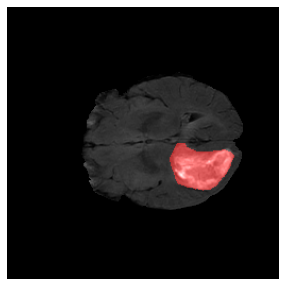

In [61]:
from skimage import io, color
slice = 130
plt.figure(figsize=(8,5))
image_show = np.array((high_reso_image / high_reso_image.max()*1.0)*255,dtype=np.uint8)
plt.imshow(color.label2rgb(np.array(np.array(final_image[0])[:,:,slice]>0.5),image_show[0,:,:,slice],colors=[(255,0,0)],alpha=0.002, bg_label=0, bg_color=None))
plt.grid(False)
plt.axis(False)
plt.show()

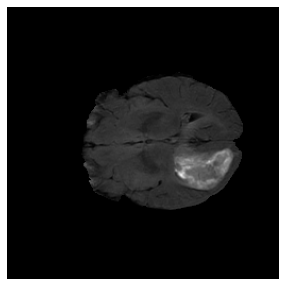

In [60]:
from skimage import io, color
slice = 130
plt.figure(figsize=(8,5))
image_show = np.array((high_reso_image / high_reso_image.max()*1.0)*255,dtype=np.uint8)
plt.imshow(color.label2rgb(np.array(np.array(high_mask[0])[:,:,slice]>0.5),image_show[0,:,:,slice],colors=[(255,0,0)],alpha=0, bg_label=0, bg_color=None))
plt.grid(False)
plt.axis(False)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


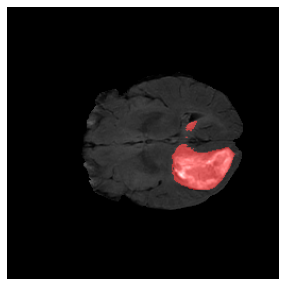

In [59]:
from skimage import io, color
slice = 130
plt.figure(figsize=(8,5))
image_show = np.array((high_reso_image / high_reso_image.max()*1.0)*255,dtype=np.uint8)
plt.imshow(color.label2rgb(np.array(np.array(high_mask[0])[:,:,slice]>0.5),image_show[0,:,:,slice],colors=[(255,0,0)],alpha=0.002, bg_label=0, bg_color=None))
plt.grid(False)
plt.axis(False)
plt.show()

In [46]:
np.array(fusion_dice_list).max()

0.9293346886660303

## voting method

In [38]:
voting_dice_list =[]
for i in range(len(dataFiles)):
    case_name = dataFiles[i]
    if os.path.exists(os.path.join('./gt_pairs/images',case_name,'x.nii.gz')):
        mask = tio.ScalarImage(os.path.join('HGG',case_name,case_name+'_seg.nii.gz'))
        transform = tio.CropOrPad(
            (256, 256, 256),
        )
        mask = transform(mask).data
        high_mask = mask


        regist_mask_x = tio.ScalarImage(os.path.join(save_folder,case_name,'regist_mask_x.nii.gz')).data
        regist_mask_y = tio.ScalarImage(os.path.join(save_folder,case_name,'regist_mask_y.nii.gz')).data
        regist_mask_z = tio.ScalarImage(os.path.join(save_folder,case_name,'regist_mask_z.nii.gz')).data
        
        obj_x = zoom(np.array(regist_mask_x),(1,2,2,2),order=1)
        obj_y = zoom(np.array(regist_mask_y),(1,2,2,2),order=1)
        obj_z = zoom(np.array(regist_mask_z),(1,2,2,2),order=1)

        regist_mask_x_final = np.array(obj_x>0.5,dtype=int)
        regist_mask_y_final = np.array(obj_y>0.5,dtype=int)
        regist_mask_z_final = np.array(obj_z>0.5,dtype=int)
        voting_mask = np.array((regist_mask_x_final + regist_mask_y_final + regist_mask_z_final)>2,dtype=int)
        
        dice_before_x = dice(obj_x[0]>0.5, np.array(high_mask[0])>0.1,nargout=1)
        dice_before_y = dice(obj_y[0]>0.5, np.array(high_mask[0])>0.1,nargout=1)
        dice_before_z = dice(obj_z[0]>0.5, np.array(high_mask[0])>0.1,nargout=1)
        dice_high_voting =  dice(np.array(voting_mask[0])>0.5, np.array(high_mask[0])>0.1,nargout=1)
        print('orignal_x dice: %f, orginal_y dice: %f, orginal_z dice: %.2f, final fusion dice: %.2f'%(dice_before_x,dice_before_y,dice_before_z,dice_high_voting))
        voting_dice_list.append(dice_high_voting)

orignal_x dice: 0.798691, orginal_y dice: 0.805066, orginal_z dice: 0.79, final fusion dice: 0.84
orignal_x dice: 0.871302, orginal_y dice: 0.871793, orginal_z dice: 0.90, final fusion dice: 0.86
orignal_x dice: 0.883311, orginal_y dice: 0.835631, orginal_z dice: 0.91, final fusion dice: 0.85
orignal_x dice: 0.779321, orginal_y dice: 0.850210, orginal_z dice: 0.89, final fusion dice: 0.81
orignal_x dice: 0.865429, orginal_y dice: 0.833867, orginal_z dice: 0.87, final fusion dice: 0.87
orignal_x dice: 0.885389, orginal_y dice: 0.921340, orginal_z dice: 0.91, final fusion dice: 0.91
orignal_x dice: 0.911573, orginal_y dice: 0.916554, orginal_z dice: 0.89, final fusion dice: 0.90
orignal_x dice: 0.870815, orginal_y dice: 0.870918, orginal_z dice: 0.86, final fusion dice: 0.90
orignal_x dice: 0.890393, orginal_y dice: 0.863694, orginal_z dice: 0.87, final fusion dice: 0.87
orignal_x dice: 0.868685, orginal_y dice: 0.862117, orginal_z dice: 0.87, final fusion dice: 0.90
orignal_x dice: 0.83

In [42]:
np.array(voting_dice_list).max()

0.9286629098360656

## check overlap of regist x and y and z

In [61]:
dice_overlap_list =[]
for i in range(len(dataFiles)):
    case_name = dataFiles[i]
    regist_mask_x = tio.ScalarImage(os.path.join(save_folder,case_name,'regist_mask_y.nii.gz')).data
    regist_mask_y = tio.ScalarImage(os.path.join(save_folder,case_name,'regist_mask_z.nii.gz')).data
    dice_high_overlap =  dice(np.array(regist_mask_x)>0.5, np.array(regist_mask_y)>0.5,nargout=1)
    dice_overlap_list.append(dice_high_overlap)

In [62]:
np.array(dice_overlap_list).mean()

0.8710809370162318

In [51]:
dice_overlap_list = []
for i in range(len(dataFiles)):
    case_name = dataFiles[i]
    dataroot = './generated_pairs_8/images/' + case_name
    labelroot = './generated_pairs_8/images/' + case_name
    ####### Image Pre-processing ##############################################
    dataFile= os.path.join(dataroot, 'x.nii.gz')
    labelFile = os.path.join(labelroot, 'y.nii.gz')
    aligned_img_x,regist_flow,image_x,gt_x,pre_segA_x,pre_segB_x,regist_mask_x = test(dataFile,labelFile,0)
    dice_overlap = dice(np.array(pre_segA_x)>0.5, np.array(pre_segB_x)>0.5,nargout=1)
    dice_overlap_list.append(dice_overlap[0])
    print('dice for overlap x and y')
    print(dice_overlap[0])

test volume = ./generated_pairs_8/images/Brats18_TCIA03_199_1/x.nii.gz
0.9606083496467784
0.9598865391214825
dice for overlap x and y
0.865902948843661
test volume = ./generated_pairs_8/images/Brats18_TCIA03_257_1/x.nii.gz
0.9322826291183589
0.9291583401248144
dice for overlap x and y
0.869574547990772
test volume = ./generated_pairs_8/images/Brats18_TCIA03_265_1/x.nii.gz
0.9437463754107868
0.9418051735237315
dice for overlap x and y
0.888292992731635
test volume = ./generated_pairs_8/images/Brats18_TCIA03_296_1/x.nii.gz
0.9578308385613641
0.9559448206249738
dice for overlap x and y
0.8860592639460086
test volume = ./generated_pairs_8/images/Brats18_TCIA03_338_1/x.nii.gz
0.9360645412107204
0.933107196265091
dice for overlap x and y
0.820838627700127
test volume = ./generated_pairs_8/images/Brats18_TCIA03_375_1/x.nii.gz
0.9520121447427639
0.9497959128507325
dice for overlap x and y
0.8557373424718108
test volume = ./generated_pairs_8/images/Brats18_TCIA03_419_1/x.nii.gz
0.95074102125076

In [56]:
np.array(dice_overlap_list).mean()

0.8857794328245548

In [55]:
dice_overlap_list = []
for i in range(len(dataFiles)):
    case_name = dataFiles[i]
    dataroot = './generated_pairs_8/images/' + case_name
    labelroot = './generated_pairs_8/images/' + case_name
    ####### Image Pre-processing ##############################################
    dataFile= os.path.join(dataroot, 'y.nii.gz')
    labelFile = os.path.join(labelroot, 'z.nii.gz')
    aligned_img_x,regist_flow,image_x,gt_x,pre_segA_x,pre_segB_x,regist_mask_x = test(dataFile,labelFile,0)
    dice_overlap = dice(np.array(pre_segA_x)>0.5, np.array(pre_segB_x)>0.5,nargout=1)
    dice_overlap_list.append(dice_overlap[0])
    print('dice for overlap y and z')
    print(dice_overlap[0])

test volume = ./generated_pairs_8/images/Brats18_TCIA03_199_1/y.nii.gz
0.9614747571269311
0.9604291918954192
dice for overlap y and z
0.8858182533438238
test volume = ./generated_pairs_8/images/Brats18_TCIA03_257_1/y.nii.gz
0.9377154304283061
0.9330254547046335
dice for overlap y and z
0.8955923645637446
test volume = ./generated_pairs_8/images/Brats18_TCIA03_265_1/y.nii.gz
0.9457984083717599
0.9443996894819329
dice for overlap y and z
0.8803017364076288
test volume = ./generated_pairs_8/images/Brats18_TCIA03_296_1/y.nii.gz
0.9582950979907924
0.9554105064485687
dice for overlap y and z
0.8990721649484537
test volume = ./generated_pairs_8/images/Brats18_TCIA03_338_1/y.nii.gz
0.9415154376868432
0.9355439823245199
dice for overlap y and z
0.8002183406113537
test volume = ./generated_pairs_8/images/Brats18_TCIA03_375_1/y.nii.gz
0.9534611188189496
0.9524234435205841
dice for overlap y and z
0.8749377179870453
test volume = ./generated_pairs_8/images/Brats18_TCIA03_419_1/y.nii.gz
0.953564644

In [10]:
def drawContour(m,s,c,RGB):
    """Draw edges of contour 'c' from segmented image 's' onto 'm' in colour 'RGB'"""
    # Fill contour "c" with white, make all else black
    thisContour = s.point(lambda p:p==c and 255)
    # DEBUG: thisContour.save(f"interim{c}.png")

    # Find edges of this contour and make into Numpy array
    thisEdges   = thisContour.filter(ImageFilter.FIND_EDGES)
    thisEdgesN  = np.array(thisEdges)

    # Paint locations of found edges in color "RGB" onto "main"
    m[np.nonzero(thisEdgesN)] = RGB
    return m

In [12]:
image = tio.ScalarImage(os.path.join('HGG',case_name,case_name+'_flair.nii.gz'))
transform = tio.CropOrPad(
    (256, 256, 256),
)
image = transform(image).data
high_reso_image = image

In [20]:
high_mask.shape

torch.Size([1, 256, 256, 256])

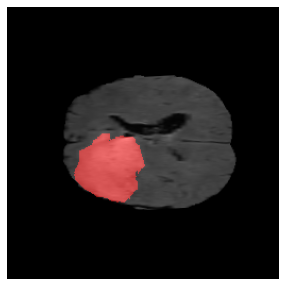

In [25]:
from skimage import io, color
slice = 140
plt.figure(figsize=(8,5))
image_show = np.array((high_reso_image / high_reso_image.max()*1.0)*255,dtype=np.uint8)
plt.imshow(color.label2rgb(np.array(np.array(high_mask[0])[:,:,slice]>0.5),image_show[0,:,:,slice],colors=[(255,0,0)],alpha=0.002, bg_label=0, bg_color=None))
plt.grid(False)
plt.axis(False)
plt.show()

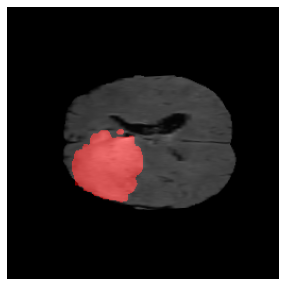

In [26]:
from skimage import io, color
slice = 140
plt.figure(figsize=(8,5))
image_show = np.array((high_reso_image / high_reso_image.max()*1.0)*255,dtype=np.uint8)
plt.imshow(color.label2rgb(np.array(np.array(zoom(regist_mask_y,(2,2,2),order=1))[:,:,slice]>0.5),image_show[0,:,:,slice],colors=[(255,0,0)],alpha=0.002, bg_label=0, bg_color=None))
plt.grid(False)
plt.axis(False)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


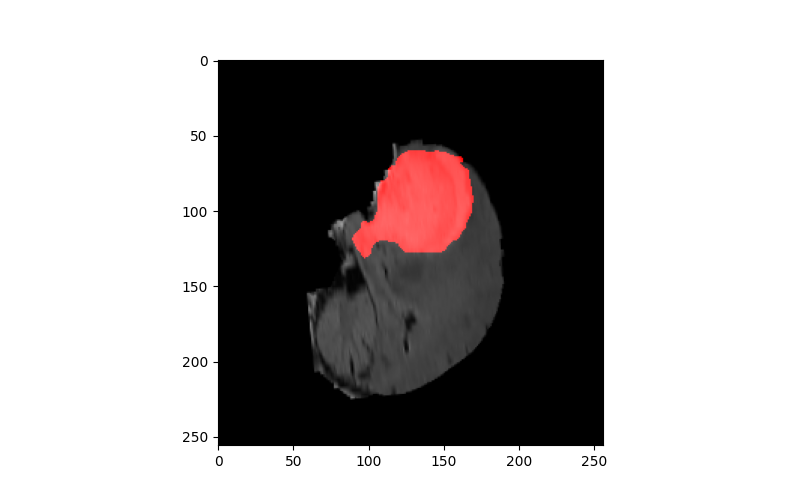

In [178]:
plt.figure(figsize=(8,5))
slice = 150
image_show = np.array((high_reso_image / high_reso_image.max()*1.0)*255,dtype=np.uint8)
plt.imshow(color.label2rgb(np.array(final_image[0,slice]>0.5),image_show[0,slice],colors=[(255,0,0)],alpha=0.005, bg_label=0, bg_color=None))
plt.grid(False)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


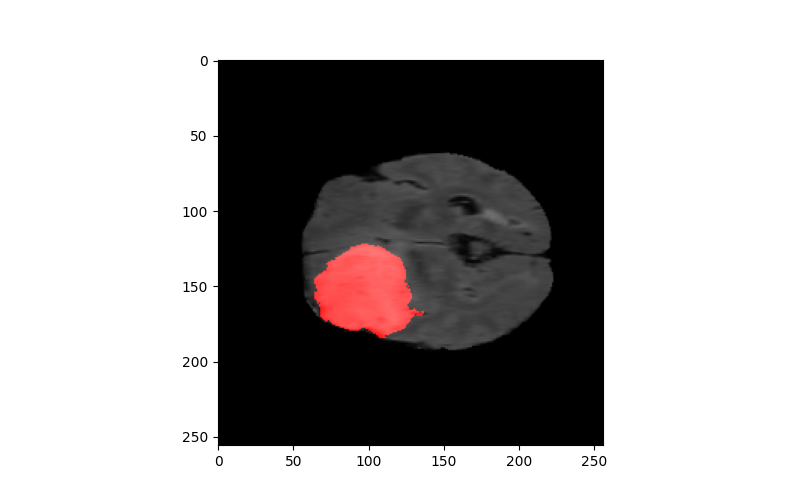

In [179]:
from skimage import io, color
plt.figure(figsize=(8,5))
slice = 120
image_show = np.array((high_reso_image / high_reso_image.max()*1.0)*255,dtype=np.uint8)
plt.imshow(color.label2rgb(np.array(high_mask[0,:,:,slice]>0.5),image_show[0,:,:,slice],colors=[(255,0,0)],alpha=0.005, bg_label=0, bg_color=None))
plt.grid(False)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


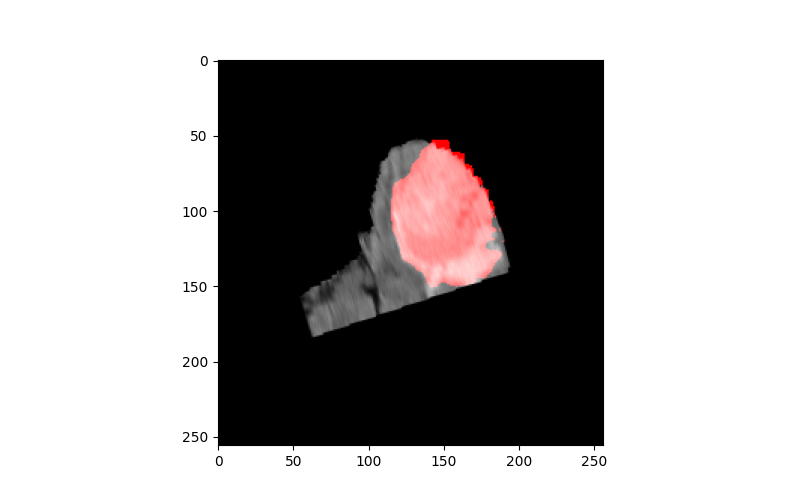

In [151]:
plt.figure(figsize=(8,5))
image_show = np.array((high_reso_image / high_reso_image.max()*1.0)*255,dtype=np.uint8)
plt.imshow(color.label2rgb(np.array(final_image[0,142]>0.5),image_show[0,142],colors=[(255,0,0)],alpha=0.005, bg_label=0, bg_color=None))
plt.grid(False)
plt.show()

In [149]:
print('dice for high resolution mask')
print(dice(np.array(final_image[0]), np.array(high_mask[0])>0.1,nargout=1))

dice for high resolution mask
[0.90167347]


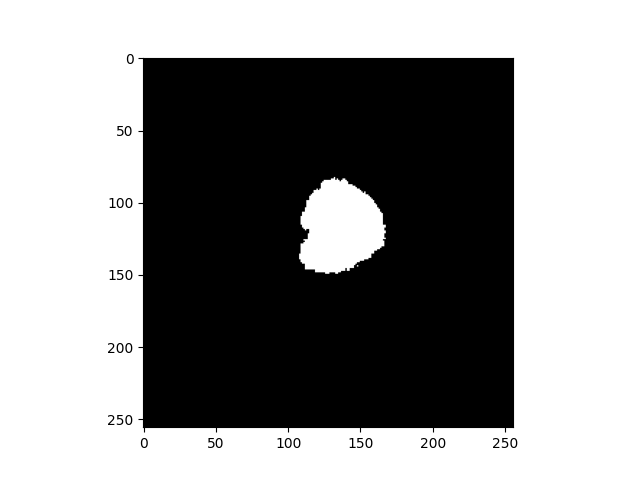

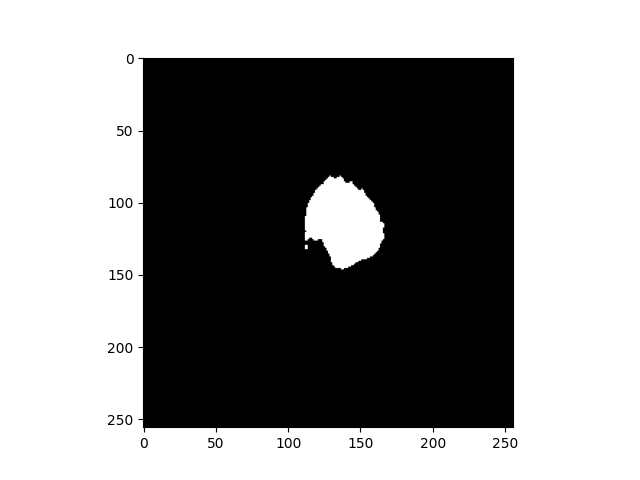

In [99]:
plt.figure()
plt.imshow(final_image[0,141,:,:]>0.5,cmap='gray')

In [ ]:
from skimage import measure
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
# points is a 3D numpy array (n_points, 3) coordinates of a sphere

verts, faces, norm, val = measure.marching_cubes(np.array(final_image[0]>0), allow_degenerate=True)
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")

ax.set_xlim(np.min(verts[:,0]), np.max(verts[:,0]))
ax.set_ylim(np.min(verts[:,1]), np.max(verts[:,1])) 
ax.set_zlim(np.min(verts[:,2]), np.max(verts[:,2]))

mesh = Poly3DCollection(verts[faces],alpha=0.4)
face_color = ['r']*len(faces)
mesh.set_facecolor(face_color)
ax.add_collection3d(mesh)

verts, faces, norm, val = measure.marching_cubes(np.array(gt_seg[0]>0), allow_degenerate=True)

ax.set_xlim(np.min(verts[:,0]), np.max(verts[:,0]))
ax.set_ylim(np.min(verts[:,1]), np.max(verts[:,1])) 
ax.set_zlim(np.min(verts[:,2]), np.max(verts[:,2]))

mesh = Poly3DCollection(verts[faces],alpha=0.4)
#mesh.set_facecolor('r')
#mesh.set_edgecolor('k')
ax.add_collection3d(mesh)

plt.tight_layout()
plt.show()

In [68]:
regist_mask_x_final = np.array(regist_mask_x>0.5,dtype=int)
regist_mask_y_final = np.array(regist_mask_y>0.5,dtype=int)
regist_mask_z_final = np.array(regist_mask_z>0.5,dtype=int)

In [69]:
fusion_mask = np.array((regist_mask_x_final + regist_mask_y_final + regist_mask_z_final)>2,dtype=int)

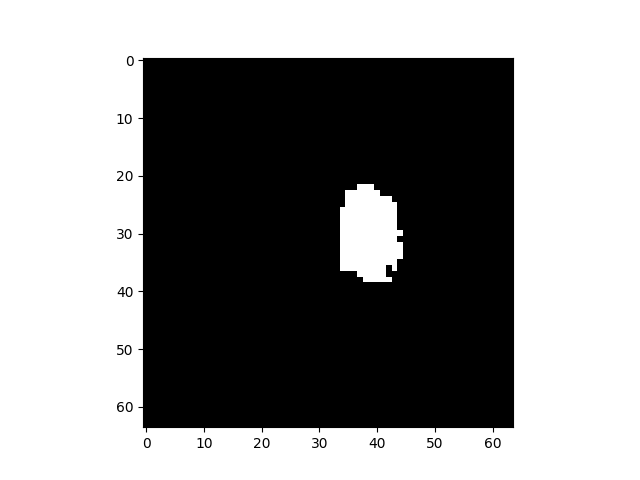

In [70]:
plt.figure()
plt.imshow(fusion_mask[35,:,:]>0.1,cmap='gray')

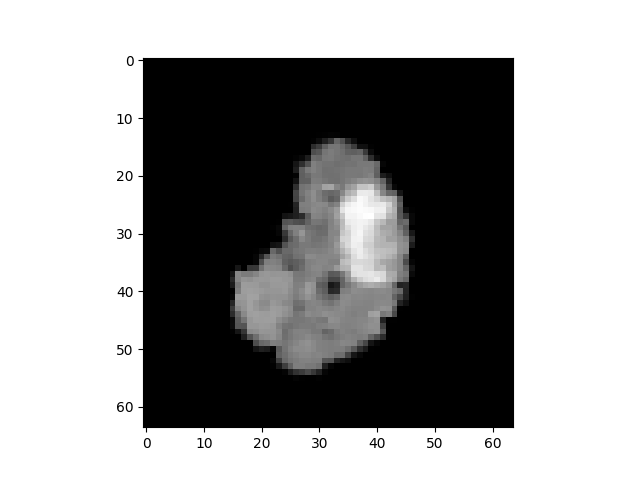

In [71]:
plt.figure()
plt.imshow(aligned_img_z[35,:,:],cmap='gray')

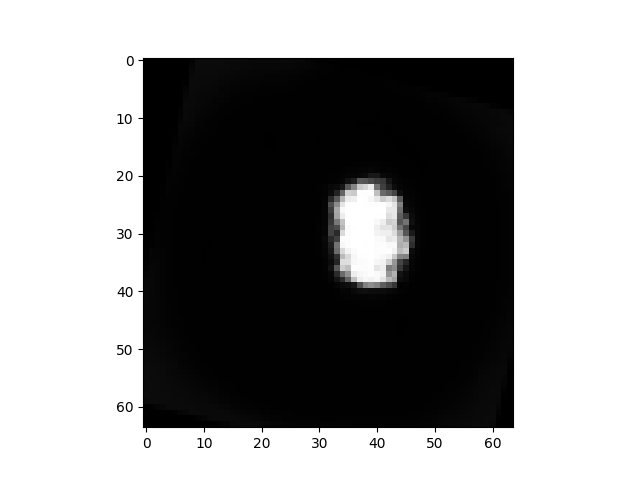

In [72]:
plt.figure()
plt.imshow(regist_mask_z[35,:,:],cmap='gray')

In [73]:
print('dice for high resolution mask z')
print(dice(np.array(fusion_mask)>0.5, np.array(high_mask[0])>0.1,nargout=1))

dice for high resolution mask z
[0.87513894]


In [268]:
point_x,point_y,point_z = np.where(label_vol>0)
X_fix = np.dot(np.concatenate((point_x.reshape(-1,1),point_y.reshape(-1,1),point_z.reshape(-1,1)),axis=1),spacing)
point_x,point_y,point_z = np.where(origin_data>0)
X_mov = np.dot(np.concatenate((point_x.reshape(-1,1),point_y.reshape(-1,1),point_z.reshape(-1,1)),axis=1),spacing)
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')
X_fix = X_fix[::10]
X_mov = X_mov[::10]
ax.scatter(X_fix[:,0],X_fix[:,1],X_fix[:,2],alpha=0.5,c='r')
ax.scatter(X_mov[:,0],X_mov[:,1],X_mov[:,2],alpha=0.5,c='b')
ax.set_box_aspect([1,1,1])

(1, 240, 240, 240)

In [356]:
dice(final_image>0, np.array(gt_seg)>0,nargout=1)

array([0.95101183])

In [371]:
dice(np.array(final_image,dtype=int), np.array(gt_seg),nargout=1)

array([0.60195159, 0.66104925, 0.        , 0.40467395])

In [378]:
np.sum(np.array(gt_x)==3)

0

In [382]:
dice(np.array(mask_z)>0, np.array(gt_seg)>0,nargout=1)

array([0.94489615])

In [346]:
## compare with gt
resample = tio.Resample((5,1,1),image_interpolation='nearest')
resampled_mask_x = resample(mask)
resample = tio.Resample((1,1,1),image_interpolation='nearest')
mask_x = resample(resampled_mask_x).data
resample = tio.Resample((1,5,1),image_interpolation='nearest')
resampled_mask_y = resample(mask)
resample = tio.Resample((1,1,1),image_interpolation='nearest')
mask_y = resample(resampled_mask_y).data
resample = tio.Resample((1,1,5),image_interpolation='nearest')
resampled_mask_z = resample(mask)
resample = tio.Resample((1,1,1),image_interpolation='nearest')
mask_z = resample(resampled_mask_z).data

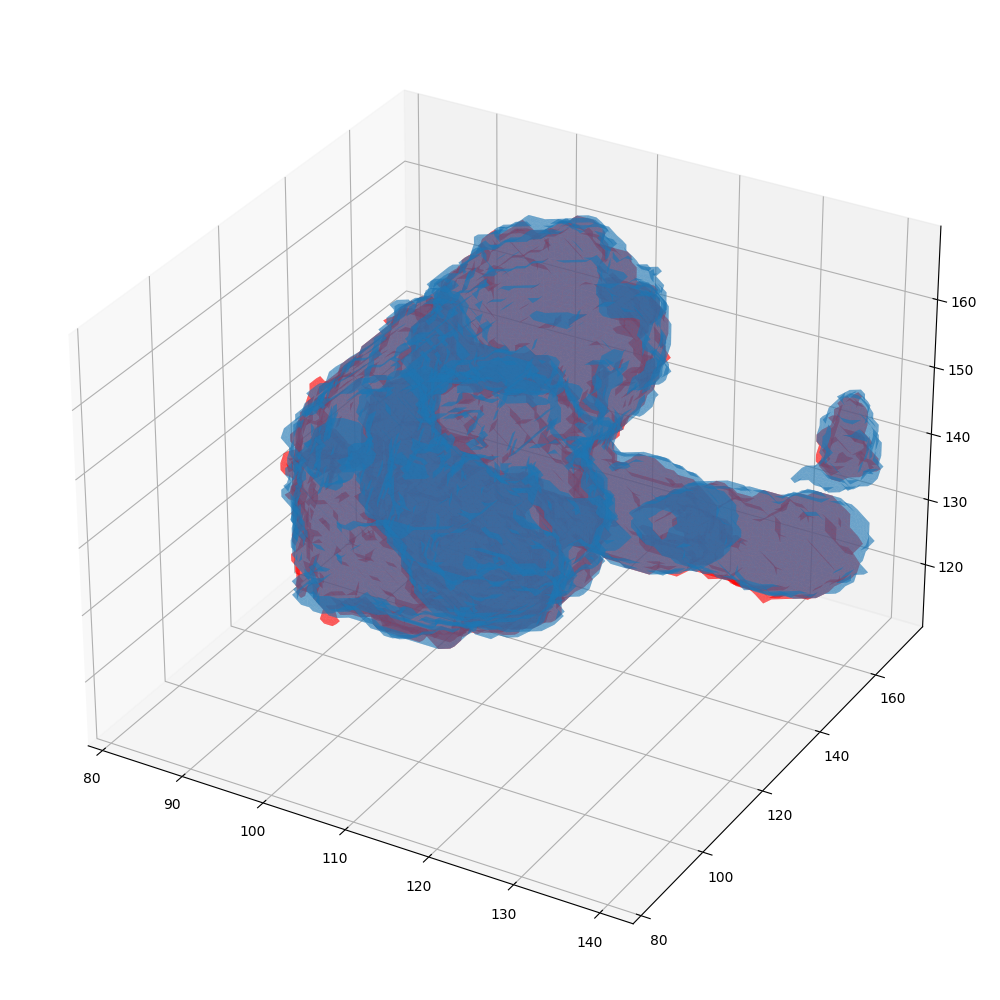

In [86]:
from skimage import measure
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
# points is a 3D numpy array (n_points, 3) coordinates of a sphere

verts, faces, norm, val = measure.marching_cubes(np.array(final_image[0]>0), allow_degenerate=True)
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")

ax.set_xlim(np.min(verts[:,0]), np.max(verts[:,0]))
ax.set_ylim(np.min(verts[:,1]), np.max(verts[:,1])) 
ax.set_zlim(np.min(verts[:,2]), np.max(verts[:,2]))

mesh = Poly3DCollection(verts[faces],alpha=0.4)
face_color = ['r']*len(faces)
mesh.set_facecolor(face_color)
ax.add_collection3d(mesh)

verts, faces, norm, val = measure.marching_cubes(np.array(gt_seg[0]>0), allow_degenerate=True)

ax.set_xlim(np.min(verts[:,0]), np.max(verts[:,0]))
ax.set_ylim(np.min(verts[:,1]), np.max(verts[:,1])) 
ax.set_zlim(np.min(verts[:,2]), np.max(verts[:,2]))

mesh = Poly3DCollection(verts[faces],alpha=0.4)
#mesh.set_facecolor('r')
#mesh.set_edgecolor('k')
ax.add_collection3d(mesh)

plt.tight_layout()
plt.show()

In [21]:
obj_z.shape

torch.Size([1, 1, 240, 240, 240])

In [213]:
point_x,point_y,point_z = np.where(obj_z[0][0]>0)
X_fix = np.dot(np.concatenate((point_x.reshape(-1,1),point_y.reshape(-1,1),point_z.reshape(-1,1)),axis=1),spacing)
point_x,point_y,point_z = np.where(gt_seg[0]>0)
X_mov = np.dot(np.concatenate((point_x.reshape(-1,1),point_y.reshape(-1,1),point_z.reshape(-1,1)),axis=1),spacing)
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')
X_fix = X_fix[::10] - 32
X_mov = X_mov[::10] - 32
ax.scatter(X_fix[:,0],X_fix[:,1],X_fix[:,2],alpha=0.2,c='r')
#ax.plot_surface(X_fix[:,0],X_fix[:,1],X_fix[:,2],alpha=0.5,c='r')
ax.scatter(X_mov[:,0],X_mov[:,1],X_mov[:,2],alpha=0.2,c='b')
ax.set_box_aspect([1,1,1])

ValueError: not enough values to unpack (expected 3, got 2)

In [16]:
img= nib.load('./generated_pairs_8/images/Brats18_2013_2_1/x.nii.gz')
gt_x = np.array(img.dataobj)
img= nib.load('./generated_pairs_8/images/Brats18_2013_2_1/y.nii.gz')
gt_y = np.array(img.dataobj)
img= nib.load('./generated_pairs_8/images/Brats18_2013_2_1/z.nii.gz')
gt_z = np.array(img.dataobj)

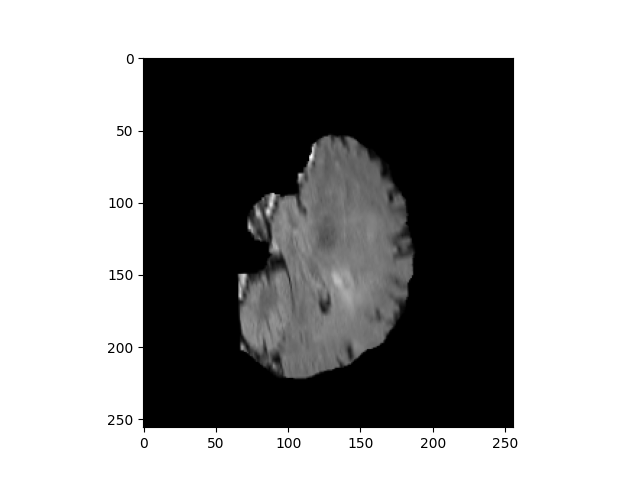

In [18]:
plt.figure()
plt.imshow(gt_x[100,:,:],cmap='gray')

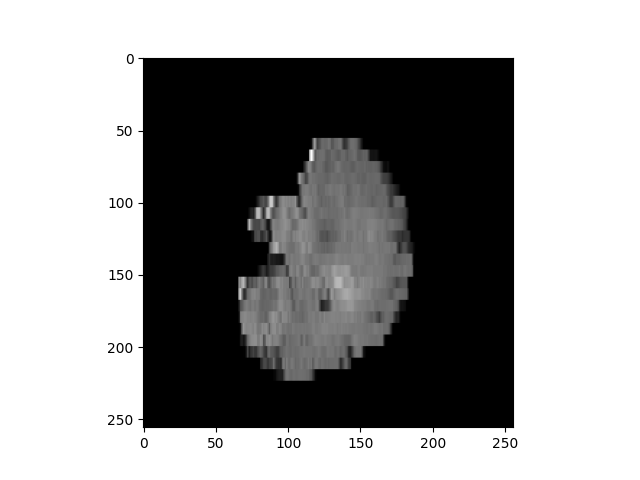

In [19]:
plt.figure()
plt.imshow(gt_y[100,:,:],cmap='gray')

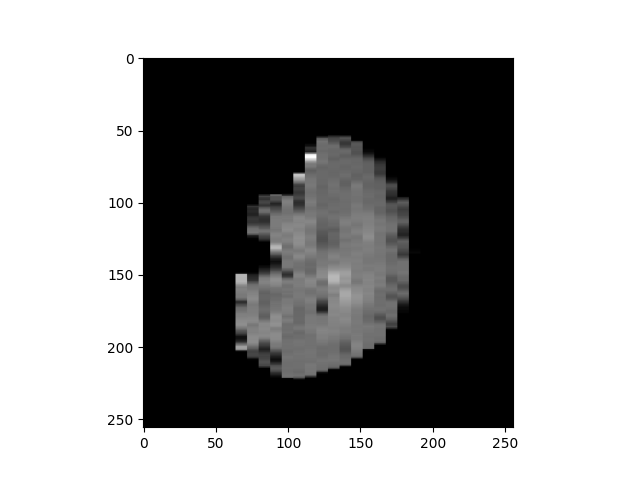

In [20]:
plt.figure()
plt.imshow(gt_z[100,:,:],cmap='gray')